# Fast Similarity Queries with Annoy and Word2Vec

In [1]:
LOGS = False  # Set to True if you want to see progress in logs.
if LOGS:
    import logging
    logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

# Download Text8 corpus

In [2]:
import gensim.downloader as api
text8_path = api.load('text8', return_path=True)
print("Using corpus from", text8_path)

Using corpus from C:\Users\AxelArcidiaco/gensim-data\text8\text8.gz


# Train the Word2Vec model

In [3]:
from gensim.models import Word2Vec, KeyedVectors
from gensim.models.word2vec import Text8Corpus

# Using params from Word2Vec_FastText_Comparison
params = {
    'alpha': 0.05,
    'vector_size': 100,
    'window': 5,
    'epochs': 5,
    'min_count': 5,
    'sample': 1e-4,
    'sg': 1,
    'hs': 0,
    'negative': 5,
}
model = Word2Vec(Text8Corpus(text8_path), **params)
wv = model.wv
print("Using trained model", wv)

Using trained model KeyedVectors<vector_size=100, 71290 keys>


# Construct AnnoyIndex with model & make a similarity query

In [6]:
from gensim.similarities.annoy import AnnoyIndexer

# 100 trees are being used in this example
annoy_index = AnnoyIndexer(model, 100)
# Derive the vector for the word "science" in our model
vector = wv["science"]
# The instance of AnnoyIndexer we just created is passed
approximate_neighbors = wv.most_similar([vector], topn=11, indexer=annoy_index)
# Neatly print the approximate_neighbors and their corresponding cosine similarity values
print("Approximate Neighbors")
for neighbor in approximate_neighbors:
    print(neighbor)

normal_neighbors = wv.most_similar([vector], topn=11)
print("\nExact Neighbors")
for neighbor in normal_neighbors:
    print(neighbor)

ImportError: Annoy not installed. To use the Annoy indexer, please run `pip install annoy`.

# Compare to the traditional indexer

In [7]:
# Set up the model and vector that we are using in the comparison
annoy_index = AnnoyIndexer(model, 100)

# Dry run to make sure both indexes are fully in RAM
normed_vectors = wv.get_normed_vectors()
vector = normed_vectors[0]
wv.most_similar([vector], topn=5, indexer=annoy_index)
wv.most_similar([vector], topn=5)

import time
import numpy as np

def avg_query_time(annoy_index=None, queries=1000):
    """Average query time of a most_similar method over 1000 random queries."""
    total_time = 0
    for _ in range(queries):
        rand_vec = normed_vectors[np.random.randint(0, len(wv))]
        start_time = time.process_time()
        wv.most_similar([rand_vec], topn=5, indexer=annoy_index)
        total_time += time.process_time() - start_time
    return total_time / queries

queries = 1000

gensim_time = avg_query_time(queries=queries)
annoy_time = avg_query_time(annoy_index, queries=queries)
print("Gensim (s/query):\t{0:.5f}".format(gensim_time))
print("Annoy (s/query):\t{0:.5f}".format(annoy_time))
speed_improvement = gensim_time / annoy_time
print ("\nAnnoy is {0:.2f} times faster on average on this particular run".format(speed_improvement))

ImportError: Annoy not installed. To use the Annoy indexer, please run `pip install annoy`.

# Persisting indices to disk

In [9]:
fname = '/tmp/mymodel.index'

# Persist index to disk
annoy_index.save(fname)

# Load index back
import os.path
if os.path.exists(fname):
    annoy_index2 = AnnoyIndexer()
    annoy_index2.load(fname)
    annoy_index2.model = model

# Results should be identical to above
vector = wv["science"]
approximate_neighbors2 = wv.most_similar([vector], topn=11, indexer=annoy_index2)
for neighbor in approximate_neighbors2:
    print(neighbor)

assert approximate_neighbors == approximate_neighbors2

NameError: name 'annoy_index' is not defined

# Save memory via memory-mapping indexes saved to disk

In [10]:
# Remove verbosity from code below (if logging active)
if LOGS:
    logging.disable(logging.CRITICAL)

from multiprocessing import Process
import os
import psutil

In [11]:
model.save('./tmp/mymodel.pkl')

def f(process_id):
    print('Process Id: {}'.format(os.getpid()))
    process = psutil.Process(os.getpid())
    new_model = Word2Vec.load('/tmp/mymodel.pkl')
    vector = new_model.wv["science"]
    annoy_index = AnnoyIndexer(new_model, 100)
    approximate_neighbors = new_model.wv.most_similar([vector], topn=5, indexer=annoy_index)
    print('\nMemory used by process {}: {}\n---'.format(os.getpid(), process.memory_info()))

# Create and run two parallel processes to share the same index file.
p1 = Process(target=f, args=('1',))
p1.start()
p1.join()
p2 = Process(target=f, args=('2',))
p2.start()
p2.join()

In [12]:
model.save('./tmp/mymodel.pkl')

def f(process_id):
    print('Process Id: {}'.format(os.getpid()))
    process = psutil.Process(os.getpid())
    new_model = Word2Vec.load('/tmp/mymodel.pkl')
    vector = new_model.wv["science"]
    annoy_index = AnnoyIndexer()
    annoy_index.load('/tmp/mymodel.index')
    annoy_index.model = new_model
    approximate_neighbors = new_model.wv.most_similar([vector], topn=5, indexer=annoy_index)
    print('\nMemory used by process {}: {}\n---'.format(os.getpid(), process.memory_info()))

# Creating and running two parallel process to share the same index file.
p1 = Process(target=f, args=('1',))
p1.start()
p1.join()
p2 = Process(target=f, args=('2',))
p2.start()
p2.join()

# Evaluate relationship of num_trees to initialization time and accuracy

In [13]:
import matplotlib.pyplot as plt

In [14]:
exact_results = [element[0] for element in wv.most_similar([normed_vectors[0]], topn=100)]

x_values = []
y_values_init = []
y_values_accuracy = []

for x in range(1, 300, 10):
    x_values.append(x)
    start_time = time.time()
    annoy_index = AnnoyIndexer(model, x)
    y_values_init.append(time.time() - start_time)
    approximate_results = wv.most_similar([normed_vectors[0]], topn=100, indexer=annoy_index)
    top_words = [result[0] for result in approximate_results]
    y_values_accuracy.append(len(set(top_words).intersection(exact_results)))

NameError: name 'normed_vectors' is not defined

NameError: name 'x_values' is not defined

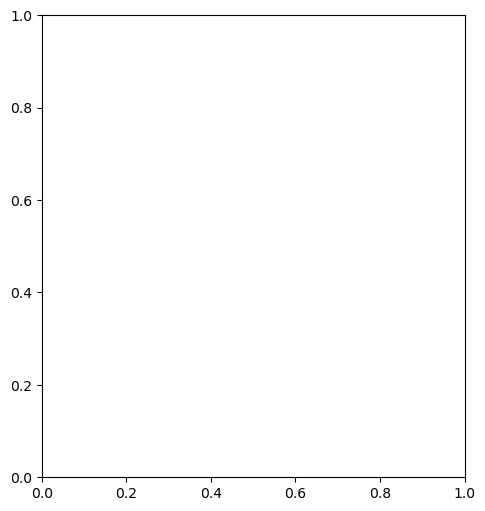

In [15]:
plt.figure(1, figsize=(12, 6))
plt.subplot(121)
plt.plot(x_values, y_values_init)
plt.title("num_trees vs initalization time")
plt.ylabel("Initialization time (s)")
plt.xlabel("num_trees")
plt.subplot(122)
plt.plot(x_values, y_values_accuracy)
plt.title("num_trees vs accuracy")
plt.ylabel("%% accuracy")
plt.xlabel("num_trees")
plt.tight_layout()
plt.show()

# Work with Google’s word2vec files

In [ ]:
# To export our model as text
wv.save_word2vec_format('/tmp/vectors.txt', binary=False)

from smart_open import open
# View the first 3 lines of the exported file
# The first line has the total number of entries and the vector dimension count.
# The next lines have a key (a string) followed by its vector.
with open('/tmp/vectors.txt', encoding='utf8') as myfile:
    for i in range(3):
        print(myfile.readline().strip())

# To import a word2vec text model
wv = KeyedVectors.load_word2vec_format('/tmp/vectors.txt', binary=False)

# To export a model as binary
wv.save_word2vec_format('/tmp/vectors.bin', binary=True)

# To import a word2vec binary model
wv = KeyedVectors.load_word2vec_format('/tmp/vectors.bin', binary=True)

# To create and save Annoy Index from a loaded `KeyedVectors` object (with 100 trees)
annoy_index = AnnoyIndexer(wv, 100)
annoy_index.save('/tmp/mymodel.index')

# Load and test the saved word vectors and saved Annoy index
wv = KeyedVectors.load_word2vec_format('/tmp/vectors.bin', binary=True)
annoy_index = AnnoyIndexer()
annoy_index.load('/tmp/mymodel.index')
annoy_index.model = wv

vector = wv["cat"]
approximate_neighbors = wv.most_similar([vector], topn=11, indexer=annoy_index)
# Neatly print the approximate_neighbors and their corresponding cosine similarity values
print("Approximate Neighbors")
for neighbor in approximate_neighbors:
    print(neighbor)

normal_neighbors = wv.most_similar([vector], topn=11)
print("\nExact Neighbors")
for neighbor in normal_neighbors:
    print(neighbor)